In [1]:
RANDOM_STATE = 42
na_filling = "imputer"
scaling = False
overSample = True

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import random
import numpy as np
import pandas as pd


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

columns = list(train_df.columns)

features = [
    'Salinity_today', 
    'Temperature_today', 
    'Substrate', 
    'Depth', 
    'Exposure', 

    'Temperature_today_exp', 
    'Depth_log', 
    'Exposure_log', 
    'Salin_div_depth',
    'Temp_div_depth',
    
]

categoricals = [
    'Substrate',
]

numerical_features = [f for f in features if f not in categoricals]

target = 'Presence'


# init
for f in features:
    if f not in train_df:
        train_df[f] = 0.0
        test_df[f]  = 0.0

# Fill Na

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


if na_filling == "imputer":
    imputer = IterativeImputer(max_iter = 10, random_state = RANDOM_STATE)
    imputer.fit(train_df[features])
    train_df[features] = pd.DataFrame(imputer.transform(train_df[features]), columns = features)
    test_df[features] = pd.DataFrame(imputer.transform(test_df[features]), columns = features)

else:
    train_df[numerical_features] = train_df[numerical_features].fillna(train_df[numerical_features].median())
    test_df[numerical_features] = test_df[numerical_features].fillna(test_df[numerical_features].median())

    train_df[categoricals] = train_df[categoricals].fillna(train_df[categoricals].mode().iloc[0])
    test_df[categoricals] = test_df[categoricals].fillna(test_df[categoricals].mode().iloc[0])

# More features

In [5]:
train_df['Exposure_log'] = np.log(train_df['Exposure'])
test_df['Exposure_log']  = np.log(test_df['Exposure'])

train_df['Depth_log'] = np.log(np.abs(train_df['Depth']))
test_df['Depth_log'] = np.log(np.abs(test_df['Depth']))

train_df['Temperature_today_exp'] = np.exp(train_df['Temperature_today'])
test_df['Temperature_today_exp'] = np.exp(test_df['Temperature_today'])

train_df['Temp_div_depth'] = train_df['Temperature_today'] / train_df['Depth']
test_df['Temp_div_depth'] = test_df['Temperature_today']   / test_df['Depth']

train_df['Salin_div_depth'] = train_df['Salinity_today'] / train_df['Depth']
test_df['Salin_div_depth'] = test_df['Salinity_today']   / test_df['Depth']

In [6]:
features = set(features)
for df in [train_df, test_df]:
    for i in range(2, 7):
        new_feature = f'Temperature_today^{i}'
        df[new_feature] = df['Temperature_today'] ** i
        features.add(new_feature)
        
features = list(features)

In [7]:
train_df.head(5)

,pointid,Salinity_today,Temperature_today,Substrate,Depth,Exposure,Presence,Temperature_today_exp,Depth_log,Exposure_log,Salin_div_depth,Temp_div_depth,Temperature_today^2,Temperature_today^3,Temperature_today^4,Temperature_today^5,Temperature_today^6
0,1557521,30.467175,6.472158,1.0,-124.810000,972065.250,0,646.878444,4.826793,13.787178,-0.244108,-0.051856,41.888834,271.111171,1754.674444,11356.530939,73501.267114
1,893106,5.571699,3.367225,0.0,-6.122131,19108.832,0,28.997952,1.811910,9.857906,-0.910091,-0.550009,11.338206,38.178291,128.554905,432.873316,1457.581937
2,1326854,6.657795,5.305255,1.0,-162.640000,772179.300,0,201.392431,5.091539,13.556972,-0.040936,-0.032620,28.145735,149.320312,792.182391,4202.729906,22296.555531
3,196477,2.744422,1.934046,0.0,-35.440000,407472.400,0,6.917444,3.567841,12.917728,-0.077439,-0.054572,3.740535,7.234369,13.991606,27.060415,52.336097
4,168448,2.797321,2.039138,1.0,-51.250000,408049.120,0,7.683983,3.936716,12.919143,-0.054582,-0.039788,4.158084,8.478907,17.289661,35.256004,71.891858


# Scaler

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.concat([train_df[numerical_features], test_df[numerical_features]], ignore_index=True)
scaler.fit(df[numerical_features])

# x_test = test_df.copy()[features]
# x_test[numerical_features] = scaler.transform(x_test[numerical_features])

StandardScaler(copy=True, with_mean=True, with_std=True)

# LogReg

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [50]:
def five_fold_cv(model, df, features, numerical_features, target, scaler, scaling=False, overSample=True, verbose = True):
    skf = StratifiedKFold(n_splits = 5)
    fold = 1
    scores = []
    
    if overSample:
        ros = RandomOverSampler()
        _, _ = ros.fit_resample(df[features], df[target])
        indices = ros.sample_indices_
        resampled_df = df.loc[indices]
        X_train, Y_train = resampled_df[features], resampled_df[target]
    else:
        X_train, Y_train = df[features], df[target]
    
    for train_index, test_index in skf.split(X_train, Y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        if scaling:
            X_train_fold = scaler.transform(X_train_fold[numerical_features])
            X_test_fold  = scaler.transform(X_test_fold[numerical_features])
        Y_train_fold, Y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        model.fit(X_train_fold, Y_train_fold)

        preds = model.predict_proba(X_test_fold)
        preds = [x[1] for x in preds]

        score = roc_auc_score(Y_test_fold, preds)
        scores.append(score)
        if verbose:
            print('Fold', fold, '     ', score)
        fold += 1
    
    avg = np.mean(scores)
    if verbose:
        print()
        print('Average:', avg)
    return avg

avg = five_fold_cv(LogisticRegression(random_state = RANDOM_STATE), 
                   train_df, features, numerical_features, target, 
                   scaler, scaling,
                   overSample,
                   verbose=True)

D:\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 1       0.9699316526690664
Fold 2       0.9713025193651794


D:\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 3       0.9715917189127602


D:\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold 4       0.9679726606662744
Fold 5       0.9717180789505994

Average: 0.970503326112776


# Catboost

In [9]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score

In [10]:
models = []

for turn_i in range(1):
    ros = RandomOverSampler()
    _, _ = ros.fit_resample(train_df[features], train_df.Presence)
    train_idx = ros.sample_indices_
    _, _ = ros.fit_resample(train_df[features], train_df.Presence)
    val_idx = ros.sample_indices_
    
    x_train, x_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
    y_train, y_val = train_df.loc[train_idx, target], train_df.loc[val_idx, target]
    
    model = CatBoostClassifier(iterations=50, verbose=False)
    model.fit(x_train, y_train)
    val_pred = model.predict(x_val)
    score = roc_auc_score(y_val, val_pred)
    models.append([score, turn_i])
    model.save_model(f"model_{turn_i}.cbm")
    print('Turn: {} score: {}'.format(turn_i, score))

Turn: 0 score: 0.9999569686754807


# Predict proba by best model

In [12]:
models.sort(key=lambda x: x[0])
best_model_i = models[-1][1]
best_model = model.load_model(f"model_{best_model_i}.cbm")
y_probas = best_model.predict_proba(test_df[features])

result = pd.read_csv("temperature_submission.csv")
result.Presence = y_probas[:, 1].round(3)
result.to_csv("submission.csv", index=False)

# Shapley values

In [13]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train_df[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [14]:
s_i = 100
shap.force_plot(explainer.expected_value, shap_values[s_i,:], train_df[features].iloc[s_i,:])

In [15]:
s_i = 0
shap.force_plot(explainer.expected_value, shap_values[s_i,:], train_df[features].iloc[s_i,:])

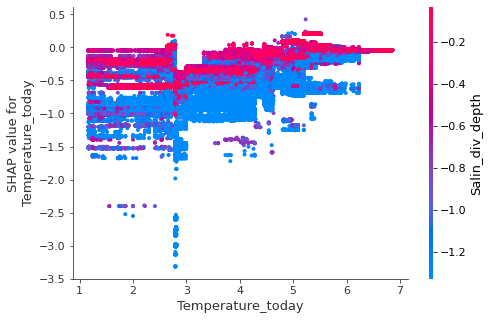

In [16]:
shap.dependence_plot("Temperature_today", shap_values, train_df[features])

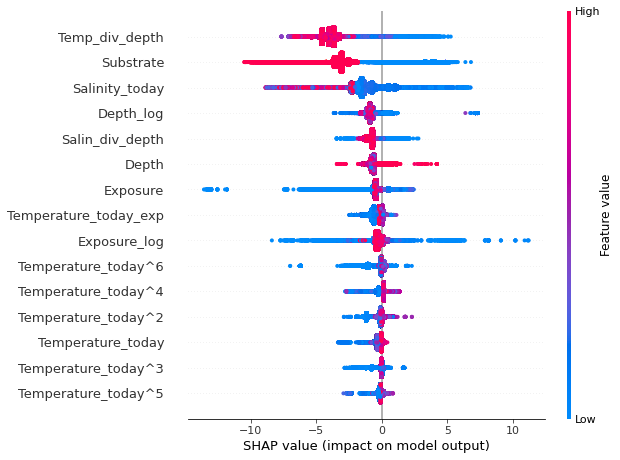

In [17]:
shap.summary_plot(shap_values, train_df[features])

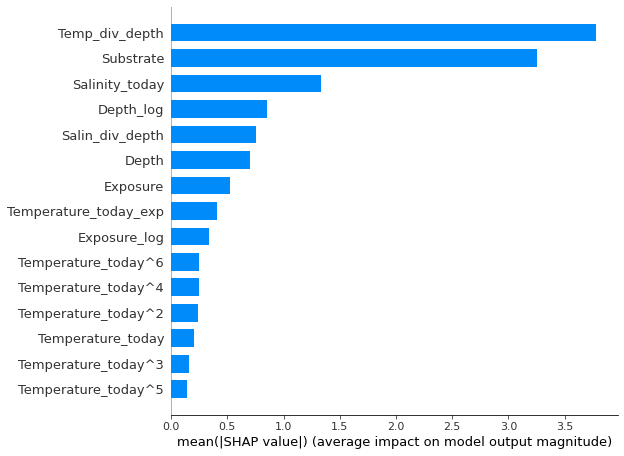

In [18]:
shap.summary_plot(shap_values, train_df[features], plot_type="bar")

# Ensemble :)

In [63]:
result = pd.read_csv("temperature_submission.csv")
result.Presence = 0

for i in range(len(models)):
    model.load_model(f"model_{i}.cbm")
    y_probas = model.predict_proba(test_df[features])
    result.Presence += y_probas[:, 1]

result.Presence = (result.Presence / len(models)).round(3)
print(f"Found killers: {sum(result.Presence)}")
result.to_csv("submission.csv", index=False)

Found killers: 56.35499999999893


In [ ]:
!kaggle competitions submit -c killer-shrimp-invasion -f submission.csv -m "Message"

https://catboost.ai/docs/concepts/python-reference_pool.html

https://catboost.ai/docs/concepts/python-reference_parameters-list.html